# Fetch and load PDB
This code acquires the pdb file from the RCSB databank, loads the necessary information, and saves copies for possible use in visualization in other software.

In [1]:
from pyCapsid.PDB import getCapsid
pdb = '4oq8'
capsid, calphas, coords, bfactors, chain_starts, title = getCapsid(pdb)

Fetching file 1 / 1 (4oq8)...
Done
Number of protein chains: 60


# Build ENM Hessian
This code builds a hessian matrix using an elastic network model defined by the given parameters. The types of model and the meaning of the parameters are provided in the documentation.

In [2]:
from pyCapsid.CG import buildENMPreset
kirch, hessian = buildENMPreset(coords, preset='U-ENM')

Building hessian for model preset:  U-ENM
Model parameters:  {'cutoff': 7.5, 'gnm': False, 'fanm': 0.1, 'wfunc': 'power', 'base_dist': 1, 'd_power': 0, 'backbone': False, 'k_backbone': 1, 'l_backbone': 1, 'chain_starts': None, 'save_hessian': False, 'save_kirchhoff': False, 'save_cg_path': './'}
Finding neighbors within 7.5Å
Building kirchhoff matrix
Building hessian matrix
Done building model


# Perform NMA
## Calculate low frequency modes
This code calculates the n lowest frequency modes of the system by calculating the eigenvalues and eigenvectors of the hessian matrix.

In [3]:
from pyCapsid.NMA import modeCalc
evals, evecs = modeCalc(hessian)

Calculating Normal Modes
Using shift-invert for increased performance with increased memory usage.
NMA time:  30.515378199983388
Saving NMA results in./modes.npz


## Predict, fit, and compare b-factors
This code uses the resulting normal modes and frequencies to predict the b-factors of each alpha carbon, fits these results to experimental values from the pdb entry, and plots the results for comparison.

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 8640
Model:                            RLM   Df Residuals:                     8639
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 30 May 2023                                         
Time:                        12:42:28                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           146.9899      0.103   1420.814      0.0

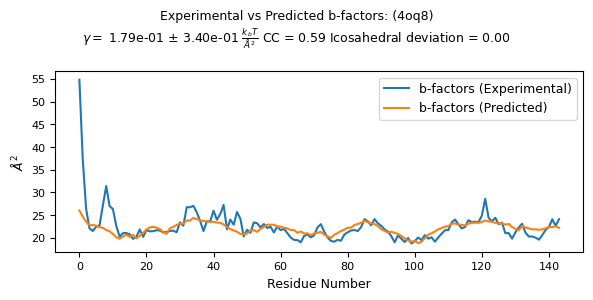

bfactor fitting time:  1.4161227999720722


In [4]:
from pyCapsid.NMA import fitCompareBfactors
evals_scaled, evecs_scaled = fitCompareBfactors(evals, evecs, bfactors, pdb)

# Perform quasi-rigid cluster identification (QRC)

Calculating sparse covariance matrix
Calculating sparse distance fluctuation matrix from covariance matrix
Performing Spectral Embedding
Clustering Embedded Points
Method: discretize
QRC time:  11.729259799933061
Plotting


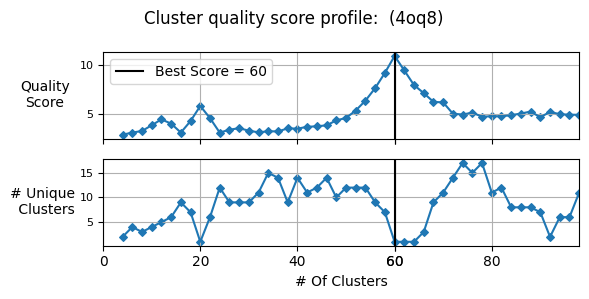

In [5]:
from pyCapsid.NMA import calcDistFlucts
from pyCapsid.QRC import findQuasiRigidClusters

dist_flucts = calcDistFlucts(evals_scaled, evecs_scaled, coords)

cluster_start = 4
cluster_stop = 100
cluster_step = 2
labels, score, residue_scores  = findQuasiRigidClusters(pdb, dist_flucts, cluster_start=cluster_start, cluster_stop=cluster_stop, cluster_step=cluster_step)

## Visualize in jupyter notebook with nglview
You can visualize the results in the notebook with nglview. The following function returns an nglview object with the results colored based on cluster. See the nglview documentation for further info (http://nglviewer.org/nglview/release/v2.7.7/index.html)

In [6]:
%reload_ext autoreload
%autoreload 2

In [15]:
from pyCapsid.VIS import view_pdb_ngl
view = view_pdb_ngl(pdb, capsid, labels)
view.download_image()
view

Each atom in this structure has the same color as other atoms in the same cluster.


NGLWidget()

Running the same code but replacing labels with residue_scores and adding rwb_scale=True visualizes the quality score of each residue. This is a measure of how rigid each residue is with respect to its cluster. Blue residues make up the cores of rigid clusters, and red residues represent borders between clusters. 

Each atom in this structure is colored according to the clustering quality score of its residue.


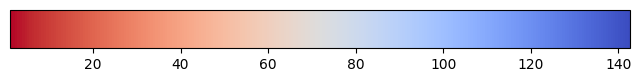

NGLWidget()

In [16]:
from pyCapsid.VIS import view_pdb_ngl
view = view_pdb_ngl(pdb, capsid, residue_scores, rwb_scale=True)
view.download_image()
view

## Visualize in ChimeraX
If ChimeraX (https://www.cgl.ucsf.edu/chimerax/download.html) is installed you may provide a path to the chimerax executable file to automatically visualize the results in chimerax. This is done using the runscript command in chimerax and this python script: (https://github.com/luquelab/pyCapsid/blob/main/src/pyCapsid/scripts/chimerax_script.py).

In [9]:
from pyCapsid.VIS import chimeraxViz
chimeraxViz(labels, pdb, chimerax_path='C:\\Program Files\\ChimeraX\\bin')

C:/Users/colin/AppData/Local/Temp/tmpbeseq15c.npy
""C:\Program Files\ChimeraX\bin" --script "C:\Users\colin\miniconda3\envs\pycaplocal\lib\site-packages\pyCapsid\scripts\chimerax_script.py C:/Users/colin/AppData/Local/Temp/tmpbeseq15c.npy . . True 4oq8 False""


Running the same code but replacing labels with residue_scores and adding rwb_scale=True visualizes the quality score of each residue. This is a measure of how rigid each residue is with respec to its cluster. Blue residues make up the cores of rigid clusters, and red residues represent borders between clusters. 

In [14]:
from pyCapsid.VIS import chimeraxViz
chimeraxViz(residue_scores, pdb, chimerax_path='C:\\Program Files\\ChimeraX\\bin\\chimerax.exe', rwb_scale=True)

C:/Users/colin/AppData/Local/Temp/tmpo24ngmw8.npy
""C:\Program Files\ChimeraX\bin\chimerax.exe" --script "C:\Users\colin\miniconda3\envs\pycaplocal\lib\site-packages\pyCapsid\scripts\chimerax_script.py C:/Users/colin/AppData/Local/Temp/tmpo24ngmw8.npy . . True 4oq8 True""
